<a href="https://colab.research.google.com/github/j0rd1smit/CS4245_cv_project_zebra_fish/blob/master/notebooks/colab/Detectron2_zebra_fish_segmatation-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2: Zebrafish

<table align="left">
<tbody><tr><td>
   <a target="_blank" href="https://colab.research.google.com/github/j0rd1smit/CS4245_cv_project_zebra_fish/blob/master/notebooks/colab/Detectron2_zebra_fish_segmatation-colab.ipynb">
     <img src="https://camo.githubusercontent.com/dfbf50eed8dd2dea5f3e0beaaf2001eeca77f314/68747470733a2f2f7777772e74656e736f72666c6f772e6f72672f696d616765732f636f6c61625f6c6f676f5f333270782e706e67" data-canonical-src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab
   </a>
 </td>
<td>
   <a target="_blank" href="https://github.com/j0rd1smit/CS4245_cv_project_zebra_fish/blob/master/notebooks/colab/Detectron2_zebra_fish_segmatation-colab.ipynb">
     <img width="32px" src="https://camo.githubusercontent.com/9a6bfd119aeed95f13553a994f2d1cd97e033768/68747470733a2f2f7777772e74656e736f72666c6f772e6f72672f696d616765732f4769744875622d4d61726b2d333270782e706e67" data-canonical-src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a>
 </td>
</tr></tbody></table>

## Install detectron2

In [25]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-c64veeg_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-c64veeg_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266987 sha256=9984c3366ce4c44ec7cabecea558ffb8e1e7ba74a60ad4a2e499db2391bdc445
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mjngt0_/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [26]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


In [27]:
!git clone https://github.com/j0rd1smit/CS4245_cv_project_zebra_fish.git
!cd CS4245_cv_project_zebra_fish

Cloning into 'CS4245_cv_project_zebra_fish'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 169 (delta 59), reused 128 (delta 25), pack-reused 0
Receiving objects: 100% (169/169), 31.00 MiB | 20.98 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [0]:
import os
os.chdir("CS4245_cv_project_zebra_fish")

## Train on a custom dataset

In [0]:
#General
import os
import numpy as np

# custom code
from zebrafish.configs import get_default_instance_segmentation_config, load_config
from zebrafish.dataset import register_datasets, load_all_image_in_dataset
from zebrafish.evaluation import coco_evaluation, coco_evaluation_all_model
from zebrafish.model import predict
from zebrafish.trainers import TrainingUtil
from zebrafish.visualization import plot_prediction, plot_train_vs_validation_loss, plot_segementation, plot_segementation_vs_real
from zebrafish.utils import is_in_main_dir

#detectron
from detectron2.utils.logger import setup_logger


setup_logger()

if "notebooks" in os.getcwd() and "colab" in os.getcwd():
    os.chdir("..")
    os.chdir("..")

assert is_in_main_dir(), "The notebook expectes you to be in the main directory"

register_datasets("dataset")

In [0]:
max_iter = 10
use_direction_classes = True

# Create a new model everytime you run this cell
cfg = get_default_instance_segmentation_config(
    use_direction_classes,
    max_iter=max_iter
)

# Loads an old model
# cfg = load_config(path_to_model) # load cfg from disk
# use_direction_classes = cfg.DATASETS.USE_DIRECTION_CLASSES # load use_direction_classes from disk

In [0]:
from detectron2.data import transforms

class DatasetMapperTTA:
    """
    Implement test-time augmentation for detection data.
    It is a callable which takes a dataset dict from a detection dataset,
    and returns a list of dataset dicts where the images
    are augmented from the input image by the transformations defined in the config.
    This is used for test-time augmentation.
    """

    def __init__(self, cfg):
        self.min_sizes = cfg.TEST.AUG.MIN_SIZES
        self.max_size = cfg.TEST.AUG.MAX_SIZE
        self.flip = cfg.TEST.AUG.FLIP
        self.image_format = cfg.INPUT.FORMAT
        self.angles = (0, 90, 180, 270)

    def __call__(self, dataset_dict):
        """
        Args:
            dict: a detection dataset dict in standard format

        Returns:
            list[dict]:
                a list of dataset dicts, which contain augmented version of the input image.
                The total number of dicts is ``len(min_sizes) * (2 if flip else 1)``.
                Each dict has field "transforms" which is a TransformList,
                containing the transforms that are used to generate this image.
        """
        numpy_image = dataset_dict["image"].permute(1, 2, 0).numpy()
        shape = numpy_image.shape
        orig_shape = (dataset_dict["height"], dataset_dict["width"])
        if shape[:2] != orig_shape:
            # It transforms the "original" image in the dataset to the input image
            pre_tfm = ResizeTransform(orig_shape[0], orig_shape[1], shape[0], shape[1])
        else:
            pre_tfm = NoOpTransform()

        # Create all combinations of augmentations to use
        tfm_gen_candidates = []  # each element is a list[TransformGen]
        for min_size in self.min_sizes:
            for angle in angles:
                #resize = ResizeShortestEdge(min_size, self.max_size)
                rotate = RotationTransform(orig_shape[0], orig_shape[1], angle)
                tfm_gen_candidates.append([rotate])  # resize only
                if self.flip:
                    flip = RandomFlip(prob=1.0)
                    tfm_gen_candidates.append([rotate, flip])

        # Apply all the augmentations
        ret = []
        for tfm_gen in tfm_gen_candidates:
            new_image, tfms = apply_transform_gens(tfm_gen, np.copy(numpy_image))
            torch_image = torch.from_numpy(np.ascontiguousarray(new_image.transpose(2, 0, 1)))

            dic = copy.deepcopy(dataset_dict)
            dic["transforms"] = pre_tfm + tfms
            dic["image"] = torch_image
            ret.append(dic)
        return ret


In [42]:
cfg.SOLVER.MAX_ITER = max_iter # Increase the number of iters here if needed.
cfg.TEST.AUG.ENABLED = True
augments = DatasetMapperTTA(cfg=cfg)
augments("dataset")

TypeError: ignored

In [33]:
resume = True # Set to true if want to continue training where use left off.
TrainingUtil.train(cfg, resume=resume)

[06/03 22:24:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (8,) in the model!


[06/03 22:24:41 d2.engine.train_loop]: Starting training from iteration 0
[06/03 22:24:53 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[06/03 22:24:53 d2.data.common]: Serialized dataset takes 0.02 MiB
[06/03 22:24:53 d2.evaluation.evaluator]: Start inference on 5 images
[06/03 22:24:54 d2.evaluation.evaluator]: Total inference time: 0:00:00.150108 (0.150108 s / img per device, on 1 devices)
[06/03 22:24:54 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.105485 s / img per device, on 1 devices)
[06/03 22:24:54 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/03 22:24:54 d2.evaluation.coco_evaluation]: Saving results to /content/CS4245_cv_project_zebra_fish/CS4245_cv_project_zebra_fish/CS4245_cv_project_zebra_fish/output/2020_06_03_22_24_40/inference/coco_instances_results.json
[06/03 22:24:54 d2.evaluation.coco_evaluation]: Evaluating predictions ...
WARNING [06/03 22:24:54 d2.evaluation.coco_eva

## Learning curve

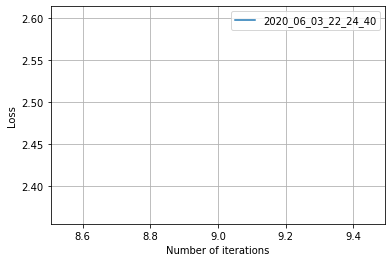

In [34]:
plot_train_vs_validation_loss([cfg.OUTPUT_DIR], show_training_loss=True)

## Evaluation

In [35]:
coco_evaluation(cfg, dataset_name="test")


Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (8,) in the model!


[06/03 22:24:57 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/03 22:24:57 d2.evaluation.coco_evaluation]: Saving results to /content/CS4245_cv_project_zebra_fish/CS4245_cv_project_zebra_fish/CS4245_cv_project_zebra_fish/output/2020_06_03_22_24_40/coco_instances_results.json
[06/03 22:24:57 d2.evaluation.coco_evaluation]: Evaluating predictions ...
WARNING [06/03 22:24:57 d2.evaluation.coco_evaluation]: No predictions from the model!
WARNING [06/03 22:24:57 d2.evaluation.coco_evaluation]: No predictions from the model!


OrderedDict([('bbox',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APl': nan,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APl': nan,
               'APm': nan,
               'APs': nan})])

## Evaluation against other models

In [36]:
bbox_df, segm_df = coco_evaluation_all_model("test")

[06/03 22:24:59 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/03 22:24:59 d2.evaluation.coco_evaluation]: Saving results to /content/CS4245_cv_project_zebra_fish/CS4245_cv_project_zebra_fish/CS4245_cv_project_zebra_fish/output/2020_06_03_22_24_40/coco_instances_results.json
[06/03 22:24:59 d2.evaluation.coco_evaluation]: Evaluating predictions ...
WARNING [06/03 22:24:59 d2.evaluation.coco_evaluation]: No predictions from the model!
WARNING [06/03 22:24:59 d2.evaluation.coco_evaluation]: No predictions from the model!


In [37]:
bbox_df

model  used_direction  max_iteration  ...  APs  APm  APl
0  output/2020_06_03_22_24_40            True             10  ...  NaN  NaN  NaN

[1 rows x 10 columns]

In [38]:
segm_df

model  used_direction  max_iteration  ...  APs  APm  APl
0  output/2020_06_03_22_24_40            True             10  ...  NaN  NaN  NaN

[1 rows x 10 columns]

## Tensorboard

In [39]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

## Visualization
Here we display the prediction for the unseen test set.

In [0]:
threshold = 0.75
n_images = 10
dataset = "test"

images = load_all_image_in_dataset(dataset, cfg)[:n_images]
predictions = predict(cfg, images, threshold=threshold)

### Prediction

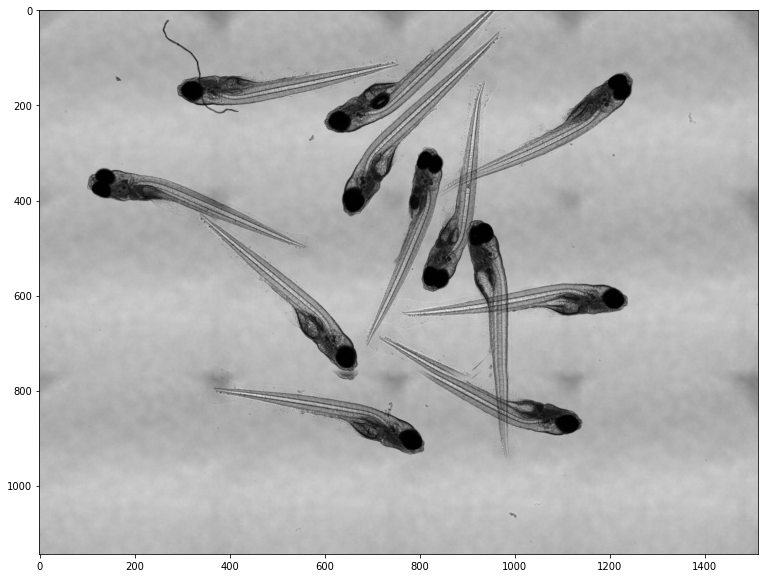

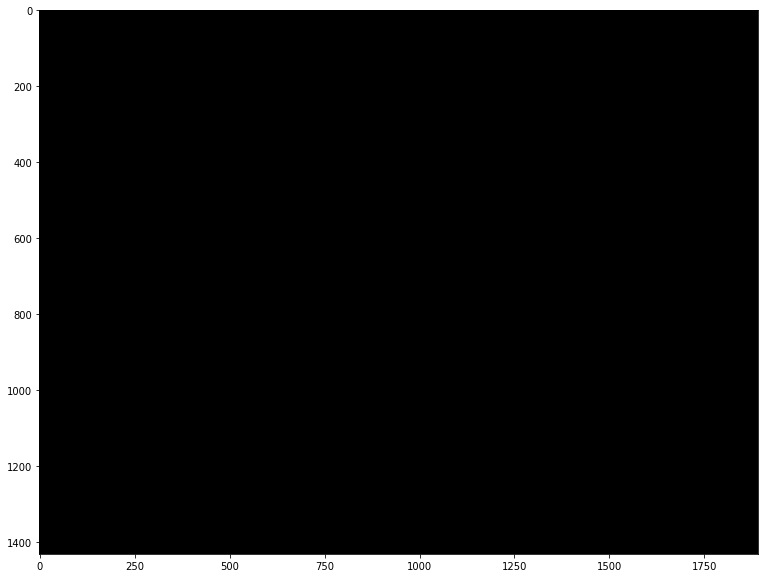

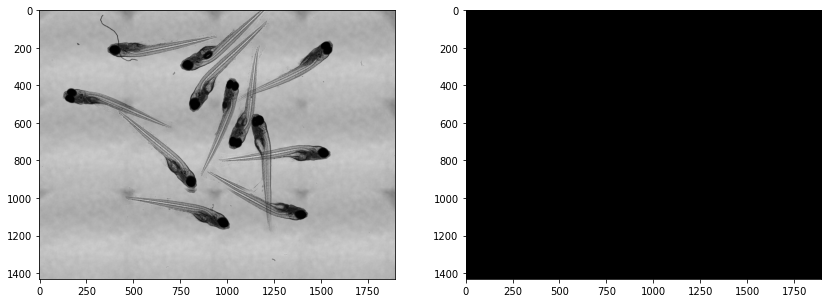

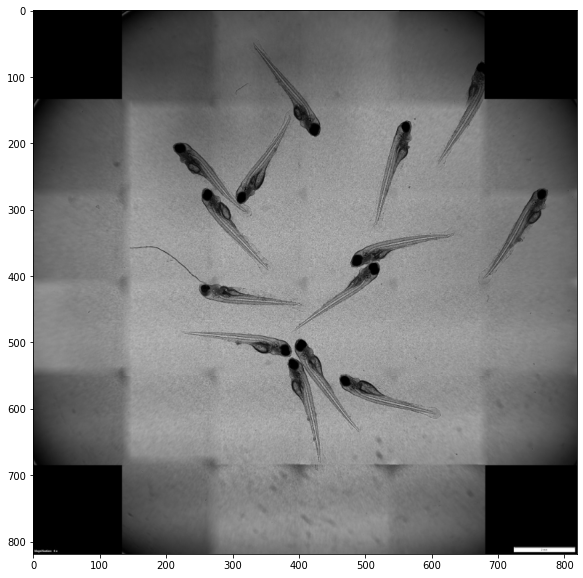

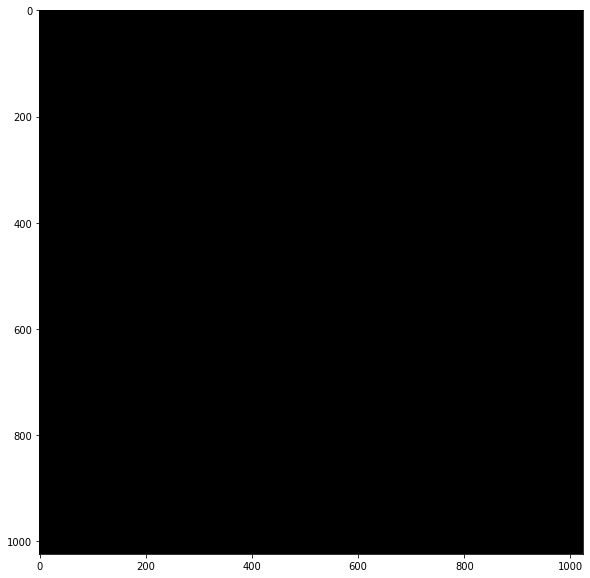

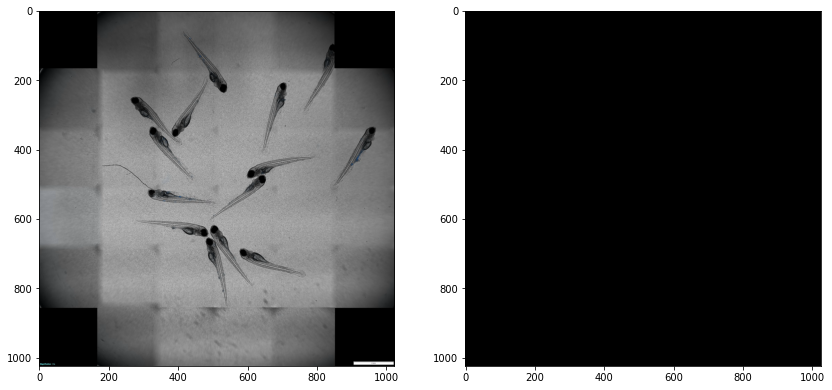

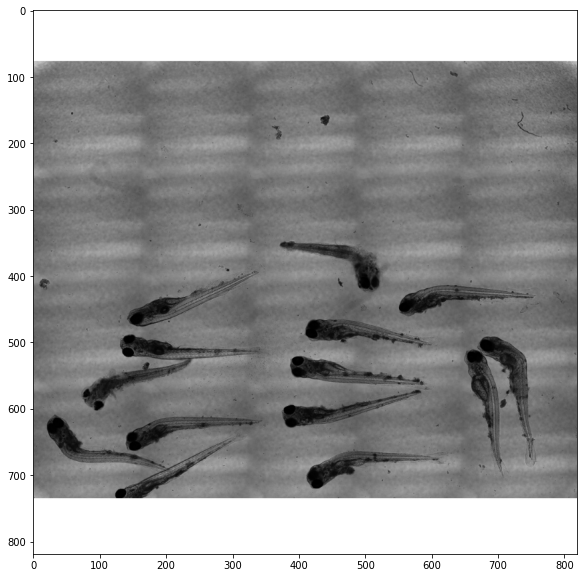

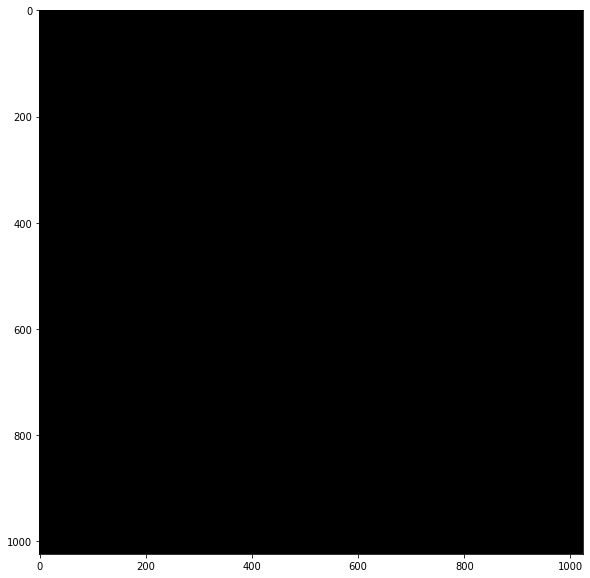

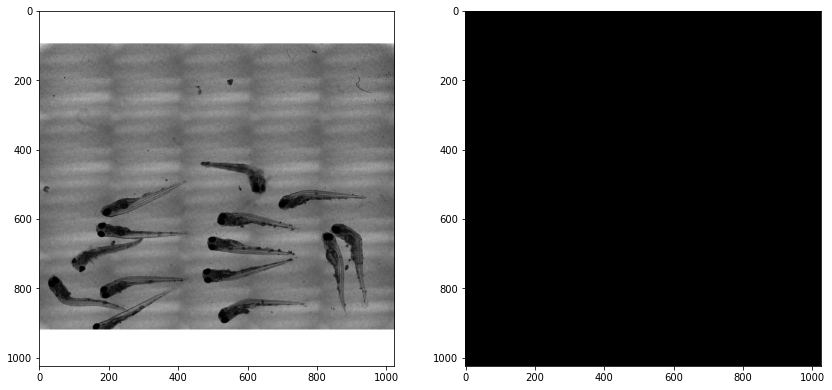

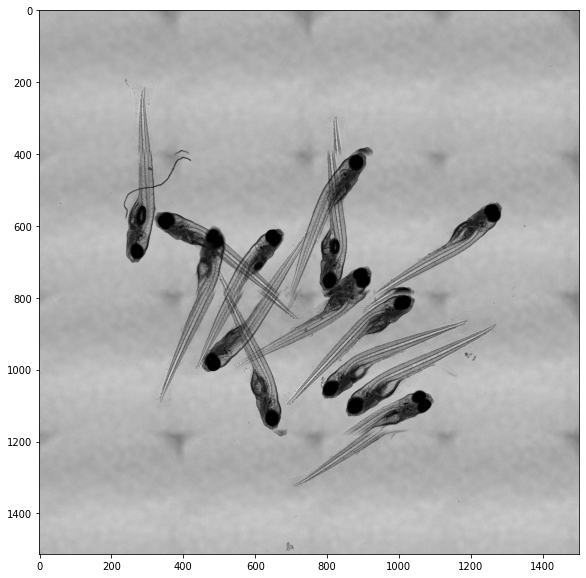

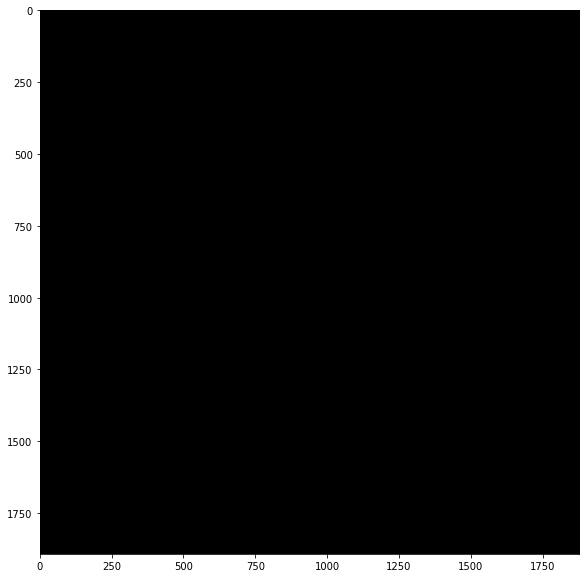

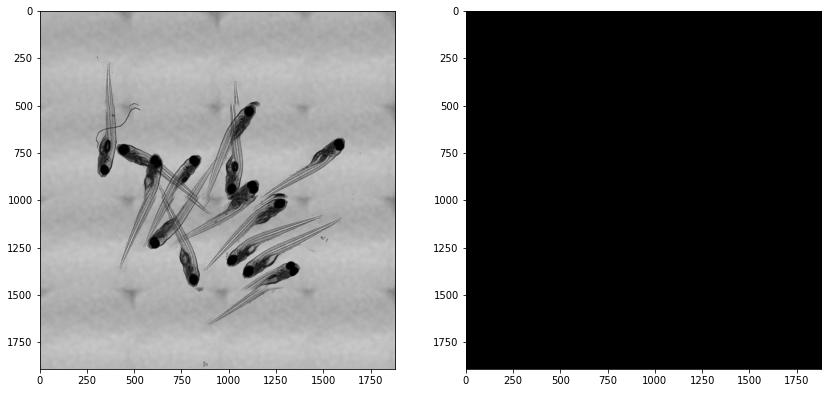

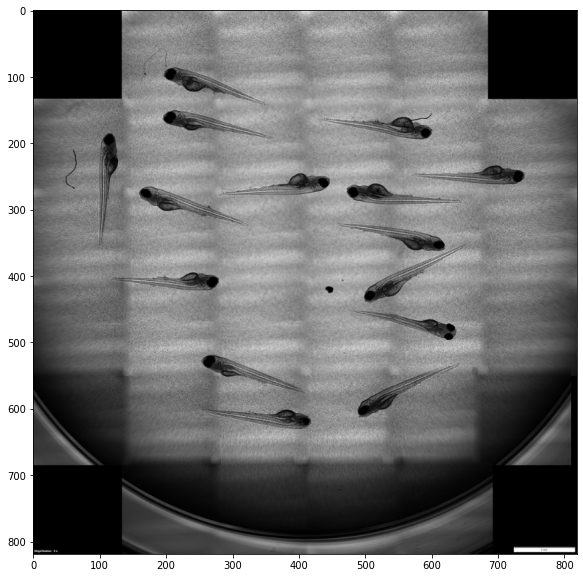

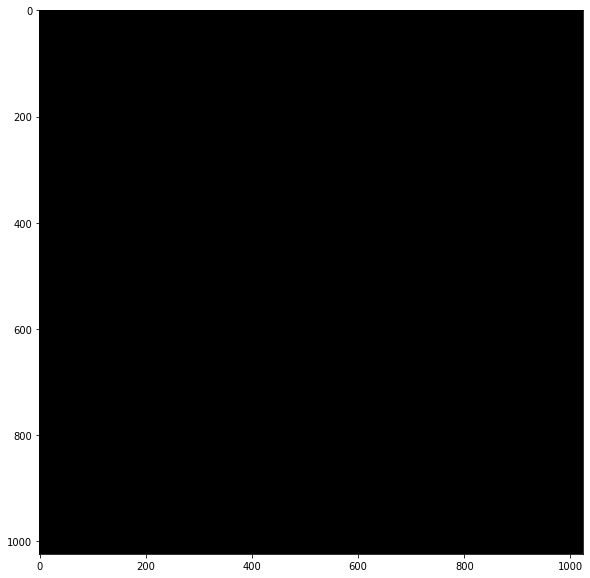

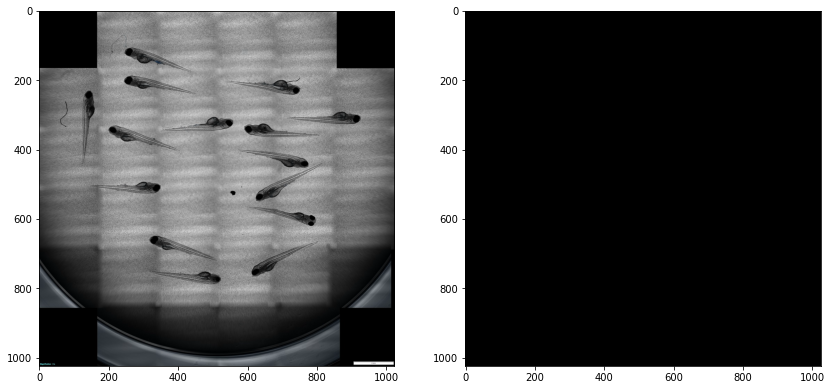

In [41]:
for image, prediction in zip(images, predictions):
    plot_prediction(image, prediction, cfg)
    plot_segementation(image, prediction)
    plot_segementation_vs_real(image, prediction)